# Brandazon User Engagement Analytics

## Background
Brandazon has recently invested in a major cross-platform strategy to boost engagement and retention across mobile and web. This includes a high-profile 2024 partnership with **Labubu** — a collectible product line driving cultural and purchasing momentum — as well as robust **A/B testing**, **push notification campaigns**, and **product scarcity mechanics**.

Recently, Brandazon launched major initiatives – including an influencer-driven Labubu partnership campaign, extensive A/B testing of features, and targeted promotions – to drive app installs, repeat purchases, and overall user activity.

## Business Objective
Leverage large-scale, multi-channel user interaction data (2023–2025) to:

- Detect behavioral signals that predict **retention**, **conversion**, or **drop-off**
- Evaluate the impact of major initiatives:
  - The **Labubu partnership campaign**
  - Seasonal and holiday promotional surges
  - **A/B tests** around scarcity, product placement, and messaging
- Compare mobile and web engagement dynamics
- Surface actionable insights to:
  - Improve **onboarding**
  - Increase **purchase frequency**
  - Optimize **campaign targeting**
  - Maximize **lifetime value**

## Stakeholders

- **Marketing and Growth Teams**  
  Understand which campaigns and creatives drive clicks, opens, and conversions.

- **Product Managers and UX Designers**  
  Use behavioral funnels and A/B test results to refine app and web features.

- **Customer Success and Retention Teams**  
  Monitor repeat purchases and build interventions for at-risk users.

- **Executive Leadership**  
  Measure the ROI of large initiatives like the Labubu partnership.

- **End Users and Customers**  
  Benefit from a more personalized, intuitive, and responsive Brandazon experience.


## Key Findings

- **Labubu-driven campaigns** were consistently linked with higher average LTV and appeared frequently in top-performing campaign combinations.
- **Influencer_push** and **seasonal campaigns** (e.g., summer_sale, winter_clearance) varied in effectiveness — some drove user volume, but not always LTV.
- Users in the **High LTV** tier interacted more frequently with events like `Checkout Started`, `Order Completed`, and `Product Viewed`, suggesting strong product consideration funnels.
- Campaigns with higher **churn rates** tended to involve lower user revenue contribution, helping identify **low-ROI acquisition tactics**.
- Most **users clustered in the Low/Medium LTV tiers**, indicating retention strategies could focus on **converting mid-tier users** into repeat purchasers.

## Raw Data Load, Parsing, and Structure Validation

This section handles the foundational setup of our Brandazon user engagement dataset.

### Steps included:
- **Multi-source loading:** We load five raw CSV files covering all major event types (`track`, `identify`, `page`, `screen`).
- **Timestamp parsing:** Timestamps are converted to datetime format to enable temporal analysis.
- **User session aliasing:** A new `session_user` column is initialized using `userId` for downstream user-level grouping.
- **Initial data audit:** A helper function (`summarize_dataset`) displays shape, column types, missing values, duplicates, and a row sample.
- **Nested JSON flattening:** The `context` and `properties` columns (originally JSON blobs) are parsed and normalized into flat columns.
- **Event integrity checks:** We validate critical structural assumptions across event types:
  - `track` events must have `event` names and valid product IDs for product-related actions.
  - `page` events should never include product IDs.
  - `screen` and `identify` events are checked for missing `name` or `traits` fields.

These checks ensure our dataset is reliable and ready for behavioral analysis across platforms.

In [103]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize

# Load and Combine Raw Data
file_list = [
    "brandazon_all_events.csv",
    "brandazon_track_sample.csv",
    "brandazon_identify_sample.csv",
    "brandazon_page_sample.csv",
    "brandazon_screen_sample.csv"
]
combined = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)

# Parse timestamp
combined['timestamp'] = pd.to_datetime(combined['timestamp'], errors='coerce')

# Assign session ID alias
combined['session_user'] = combined['userId']

# Dataset Summary Function
def summarize_dataset(df, sample_n=5):
    print("Dataset Shape:", df.shape)
    print("Column Types:\n", df.dtypes)
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print("\nMissing Values:\n", missing.sort_values(ascending=False))
    else:
        print("\nNo missing values.")
    try:
        print("\nDuplicate Rows:", df.duplicated().sum())
    except TypeError:
        print("\nDuplicate check skipped (unhashable columns).")
    print(f"\nSample {sample_n} Rows:\n", df.head(sample_n))

print("Raw Combined Data")
summarize_dataset(combined)

# Flatten Nested JSON Columns
def flatten_nested_columns(df, columns_to_flatten=['context', 'properties']):
    for col in columns_to_flatten:
        if col in df.columns:
            print(f"Flattening column: {col}")
            def parse_json(val):
                if isinstance(val, dict):
                    return val
                if pd.isna(val):
                    return {}
                try:
                    return json.loads(val)
                except Exception:
                    try:
                        return eval(val)
                    except Exception:
                        return {}
            parsed_col = df[col].apply(parse_json)
            flattened = json_normalize(parsed_col).add_prefix(f"{col}_")
            df = pd.concat([df.drop(columns=[col]), flattened], axis=1)
    return df

# Flatten context and properties
combined_flattened = flatten_nested_columns(combined)

print("Flattened Data")
summarize_dataset(combined_flattened)

# Event Integrity Checks
def check_event_structure(df):
    mask_track = df['type'] == 'track'
    if mask_track.any():
        print("track missing event:", df.loc[mask_track, 'event'].isnull().sum())
        mask_prod = mask_track & (df['event'].str.contains("Product|Order", na=False))
        print("track Product/Order missing product_id:", df.loc[mask_prod, 'properties_product_id'].isnull().sum())

    mask_page = df['type'] == 'page'
    if mask_page.any():
        print("page missing name:", df.loc[mask_page, 'name'].isnull().sum())
        print("page with product_id (should NOT exist):", df.loc[mask_page, 'properties_product_id'].notnull().sum())

    mask_screen = df['type'] == 'screen'
    if mask_screen.any():
        print("screen missing name:", df.loc[mask_screen, 'name'].isnull().sum())

    mask_identify = df['type'] == 'identify'
    if mask_identify.any():
        print("identify missing traits:", df.loc[mask_identify, 'traits'].isnull().sum())

# Run validations
check_event_structure(combined_flattened)

Raw Combined Data
Dataset Shape: (1377085, 10)
Column Types:
 anonymousId             object
userId                  object
timestamp       datetime64[ns]
type                    object
traits                  object
context                 object
name                    object
properties              object
event                   object
session_user            object
dtype: object

Missing Values:
 traits        1272085
event         1242743
name           239342
properties     105000
type           100000
dtype: int64

Duplicate Rows: 0

Sample 5 Rows:
                             anonymousId       userId           timestamp  \
0  eff180b6-259e-456b-83cf-cb338e086b12  user_000001 2024-01-30 13:53:39   
1  591a4bdb-cde9-4455-9f62-f620e53f6af5  user_000001 2024-03-05 11:45:39   
2  5f2510e4-4460-494e-b9eb-4824ed577bed  user_000001 2024-03-05 11:57:39   
3  715adfb0-a6a1-45ec-93a3-d6a11c6059c4  user_000001 2024-03-05 11:55:39   
4  9bc2d9c8-a548-4c3e-9edf-5f00c177f9bf  user_000001 2024

## Session Standardization and Timestamp Analysis

This section enhances our dataset with session-aware and time-aware fields to support user journey analysis.

### Key actions:
- **Timestamp re-parsing (redundant but safe):** Ensures all `timestamp` values are in a consistent datetime format.
- **Session user unification:** Combines `userId` and `anonymousId` into a single `session_user` column. This allows us to track user behavior regardless of authentication state.
- **Quick statistics:** 
  - Total number of events in the dataset
  - Date range coverage (min–max timestamp)
  - Counts of uniquely identified users (both logged-in and anonymous)

This lays the groundwork for cohorting users and understanding behavioral trends over time.

In [85]:
# Basic parsing: convert timestamps and unify user identifier for sessions
combined['timestamp'] = pd.to_datetime(combined['timestamp'], errors='coerce')
combined['session_user'] = combined['userId'].fillna(combined['anonymousId'])
print("Total events:", len(combined))
print("Time span:", combined['timestamp'].min(), "to", combined['timestamp'].max())
print("Unique logged-in users:", combined['userId'].nunique(), 
      "| Unique anonymous users:", combined['anonymousId'].nunique())

Total events: 1377085
Time span: 2023-01-01 00:00:37 to 2025-07-01 23:59:02
Unique logged-in users: 120000 | Unique anonymous users: 1377085


## Basic User and Event Type Exploration

This section provides an initial overview of user coverage and behavioral patterns based on the raw event data.

### Key insights generated:
- **Total unique users:** Combines both authenticated (`userId`) and anonymous (`anonymousId`) identifiers to estimate the overall user base represented in the dataset.
- **Top 10 most common events:** Identifies the most frequently occurring user actions captured in the event logs (e.g., purchases, product views, screen transitions).
- **Event type distribution:** Summarizes the high-level event categories (e.g., `track`, `identify`, `page`, `screen`) to give a sense of data diversity.

These insights guide downstream segmentation, funnel modeling, and user engagement profiling.

In [ ]:
# Basic Data Exploration

# Unique user count (including anonymous) 
user_ids = set(combined['userId'].dropna())
pure_anon_ids = set(combined.loc[combined['userId'].isnull(), 'anonymousId'].dropna())
total_unique_users = len(user_ids.union(pure_anon_ids))
print("Total unique users (including anonymous):", total_unique_users)

# Top 10 most common event types
if 'event' in combined.columns:
    top_events = combined['event'].value_counts().head(10)
    print("\nTop 10 Events:")
    for evt, count in top_events.items():
        print(f"{evt}: {count}")



print(combined['type'].value_counts())

Total unique users (including anonymous): 120000

Top 10 Events:
Product Viewed: 25224
Order Completed: 17877
Promotion Clicked: 13950
Labubu Drop Viewed: 7780
Cart Viewed: 7696
Added to Cart: 7625
Order Cancelled: 7602
Product Clicked: 7593
Product List Viewed: 7584
Removed from Cart: 7581
type
page        1018814
screen       118929
identify     105000
track         34342
Name: count, dtype: int64


## Behavioral and Campaign Analytics Overview

This section provides multiple targeted analyses to surface user engagement trends, product interest, marketing campaign impact, and potential churn behavior.

### 1. Product Popularity Analysis
We aggregate and visualize the top 10 most frequently purchased products. A product catalog mapping is applied to convert product IDs into human-readable names. This helps stakeholders understand which items are driving the most sales volume.

- **Metrics displayed:** Purchase count, average quantity, and average price per product
- **Business implication:** Useful for inventory planning, promotions, and identifying hero SKUs

### 2. Average Cart Size Distribution
We calculate the mean number of items per order and visualize the distribution across all completed purchases.

- **Key insight:** Reveals shopping behavior (e.g., impulse vs. bulk buying)
- **Use case:** Tailor upselling strategies and product bundle recommendations

### 3. Mobile App Installs Over Time
We filter mobile platform install events and plot monthly trends to assess growth and campaign timing.

- **Purpose:** Helps product and growth teams monitor acquisition over time
- **Contextual value:** Can be cross-referenced with release schedules or paid marketing pushes

### 4. Campaign Effectiveness and Revenue Impact
We examine all events associated with marketing campaigns to assess how each campaign contributed to engagement and revenue.

- **Dual-axis chart:** Compares event volume and revenue per campaign
- **Business application:** Identify high-ROI campaigns and guide future budget allocation

### 5. User Churn Analysis
We define churn based on users whose last activity occurred before a defined cutoff date (May 1, 2025), and summarize churn distribution across the user base.

- **Outputs:** Number of churned vs. active users
- **Strategic value:** Establishes a foundation for retention modeling and re-engagement initiatives

Top 10 Products by Purchase Count:
   properties_product_id  purchase_count  avg_price  avg_quantity  \
99           prod_labubu            3934     100.26             1   
85             prod_0086              88     115.74             2   
2              prod_0003              88     101.35             2   
76             prod_0077              80     110.95             2   
52             prod_0053              80     104.81             2   
6              prod_0007              76     106.57             2   
65             prod_0066              76     104.03             2   
69             prod_0070              75     111.98             2   
87             prod_0088              74     106.98             2   
47             prod_0048              73     111.21             2   

                  product_name  
99                  Labubu Toy  
85     MistyRose Building Risk  
2   YellowGreen Training Glass  
76       LightGray Without Eye  
52             Coral Just Fast  
6      

/var/folders/p6/qb4n9cmd63vczr6sz1cp91z00000gn/T/ipykernel_74929/944058105.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


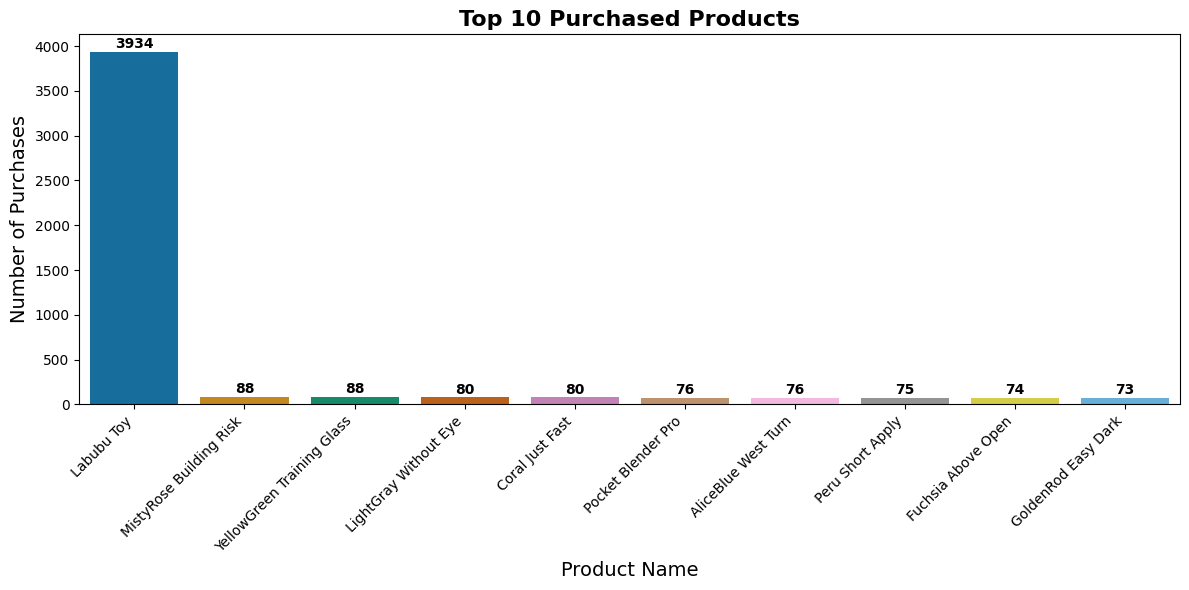

Average Cart Size (quantity per purchase): 2


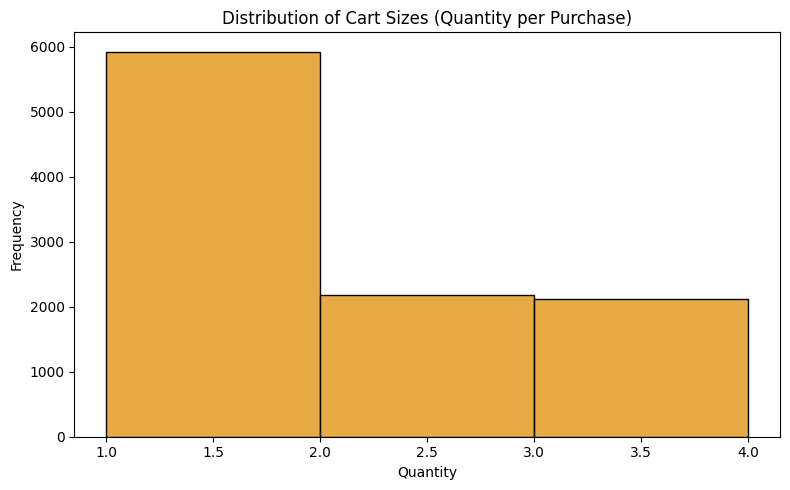

Mobile app installs over time:
        month  install_count
0  2023-01-01             61
1  2023-02-01             59
2  2023-03-01             63
3  2023-04-01             66
4  2023-05-01             59
5  2023-06-01             63
6  2023-07-01             49
7  2023-08-01             55
8  2023-09-01             46
9  2023-10-01             66
10 2023-11-01             61
11 2023-12-01             49
12 2024-01-01             62
13 2024-02-01             57
14 2024-03-01             61
15 2024-04-01             64
16 2024-05-01             67
17 2024-06-01             55
18 2024-07-01             55
19 2024-08-01             67
20 2024-09-01             58
21 2024-10-01             54
22 2024-11-01             61
23 2024-12-01             55
24 2025-01-01             50
25 2025-02-01             50
26 2025-03-01             57
27 2025-04-01             54
28 2025-05-01             68
29 2025-06-01             62
30 2025-07-01              3


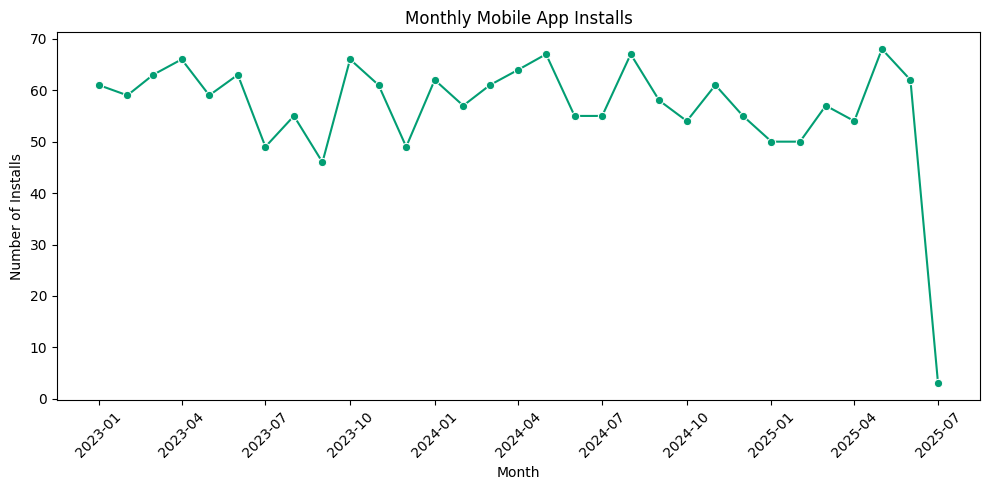

Campaign Event Counts and Revenue:
   context_campaign  event_count  total_revenue
2  labubu_drop_code       265880     1143195.33
3       summer_sale       256012      744053.87
4  winter_clearance       255410      749663.68
1   influencer_push       255268      730526.55
0     holiday_blast       239515      582644.65


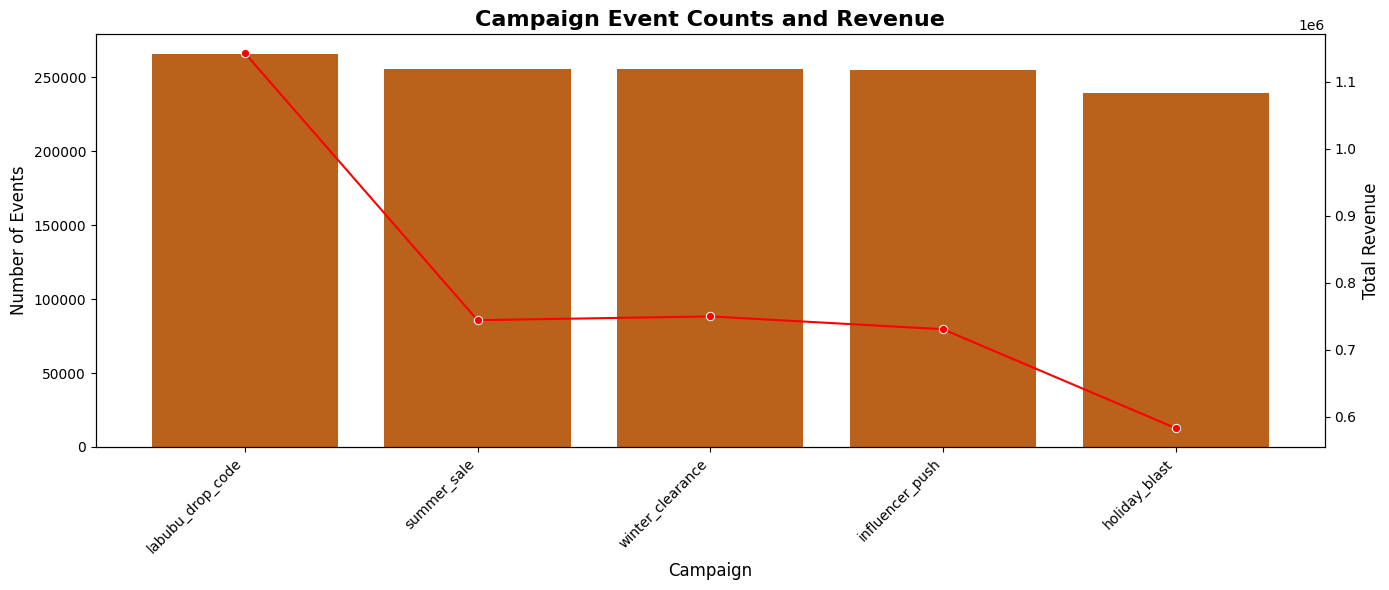

Churn value counts:
churned
False    62704
True     57296
Name: count, dtype: int64


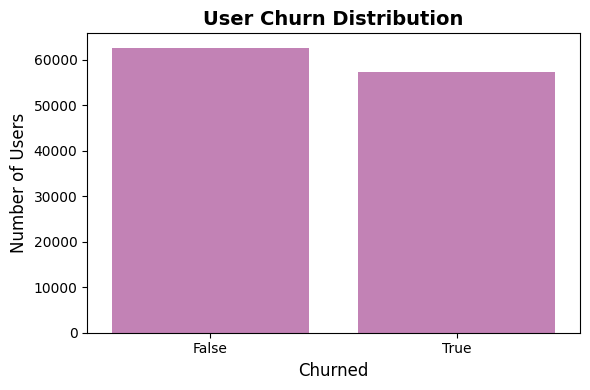

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from faker import Faker

fake = Faker()

# --- Known product catalog mapping ---
product_catalog = {
    'monopoly-3rd-edition': 'Monopoly: 3rd Edition',
    'uno-card-game': 'Uno Card Game',
    'special-facial-soap': 'Special Facial Soap',
    'fancy-hairbrush': 'Fancy Hairbrush',
    'labubu-blind-box-series-8': 'Labubu Blind Box Series 8',
    'labubu-ghost-hunter-plush': 'Labubu Ghost Hunter Plush',
    'labubu-plush-keychain': 'Labubu Plush Keychain',
    'electric-pour-over-kettle': 'Electric Pour-over Kettle',
    'retro-gaming-mousepad': 'Retro Gaming Mousepad',
    'airpods-pro-3rd-gen': 'AirPods Pro 3rd Gen',
    'nintendo-switch-lite': 'Nintendo Switch Lite',
    'collectible-ceramic-mug': 'Collectible Ceramic Mug',
    'prod_labubu': 'Labubu Toy',
    'prod_0013': 'LED Lamp',
    'prod_0091': 'Wireless Earbuds Gen2',
    'prod_0030': 'Instant Cold Brew Maker',
    'prod_0007': 'Pocket Blender Pro',
    'prod_0068': 'Smart Home Hub Mini',
    'prod_0023': 'Travel Packing Cubes',
    'prod_0033': 'UV Sanitizing Box',
    'prod_0012': 'Doggo Deluxe Bed',
    'prod_0044': 'Cat Castle Tower',
    'prod_0081': 'All-Season Yoga Mat',
    'prod_0054': 'Holiday Cookie Tin',
    # Add more known mappings as needed
}

faker_name_cache = {}

def get_faker_product_name(prod_id):
    if prod_id not in faker_name_cache:
        faker_name_cache[prod_id] = f"{fake.color_name()} {fake.word().capitalize()} {fake.word().capitalize()}"
    return faker_name_cache[prod_id]

def map_product_id_to_name(prod_id):
    if pd.isna(prod_id):
        return "Unknown Product"
    if prod_id in product_catalog:
        return product_catalog[prod_id]
    if isinstance(prod_id, str) and prod_id.startswith('prod_'):
        return get_faker_product_name(prod_id)
    return prod_id

# --- Product Popularity ---

product_purchases = combined_flattened[
    (combined_flattened['event'] == 'Order Completed') &
    (combined_flattened['properties_product_id'].notna())
].groupby('properties_product_id').agg(
    purchase_count=('event', 'count'),
    avg_price=('properties_price', lambda x: round(x.mean(), 2)),
    avg_quantity=('properties_quantity', lambda x: int(round(x.mean())))
).reset_index()

product_purchases['product_name'] = product_purchases['properties_product_id'].apply(map_product_id_to_name)
product_purchases = product_purchases.sort_values(by='purchase_count', ascending=False)

print("Top 10 Products by Purchase Count:")
print(product_purchases.head(10))

top_n = 10
top_products = product_purchases.head(top_n).copy()

palette = sns.color_palette("colorblind")[:top_n]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_products,
    x='product_name',
    y='purchase_count',
    palette=palette
)

# Add purchase count labels on bars
for i, val in enumerate(top_products['purchase_count']):
    ax.text(i, val + max(top_products['purchase_count']) * 0.01, str(val), ha='center', fontweight='bold')

plt.title('Top 10 Purchased Products', fontsize=16, fontweight='bold')
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Number of Purchases', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.subplots_adjust(bottom=0.25)  # allow room for rotated labels
plt.tight_layout()
plt.show()

# --- Average Cart Size (Quantity) ---

cart_sizes = combined_flattened[
    combined_flattened['event'] == 'Order Completed'
]['properties_quantity'].dropna()

print(f"Average Cart Size (quantity per purchase): {cart_sizes.mean():.0f}")

plt.figure(figsize=(8, 5))
sns.histplot(cart_sizes, bins=range(1, int(cart_sizes.max()) + 2), kde=False, color=palette[1])
plt.title('Distribution of Cart Sizes (Quantity per Purchase)')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Mobile App Installs Over Time ---

install_events = combined_flattened[
    combined_flattened['event'].str.contains('install', case=False, na=False) &
    (combined_flattened['context_platform'] == 'mobile')
]

if not install_events.empty:
    install_events = install_events.copy()
    install_events['month'] = install_events['timestamp'].dt.to_period('M').dt.to_timestamp()
    installs_by_month = install_events.groupby('month').size().reset_index(name='install_count')

    print("Mobile app installs over time:")
    print(installs_by_month)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=installs_by_month,
        x='month',
        y='install_count',
        marker='o',
        color=palette[2]
    )
    plt.title('Monthly Mobile App Installs')
    plt.xlabel('Month')
    plt.ylabel('Number of Installs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No mobile install events found.")

# --- Campaign Effectiveness and Revenue ---

campaign_events = combined_flattened[
    combined_flattened['context_campaign'].notna()
]

campaign_summary = campaign_events.groupby('context_campaign').agg(
    event_count=('context_campaign', 'count'),
    total_revenue=('properties_price', 'sum')
).reset_index().sort_values(by='event_count', ascending=False)

print("Campaign Event Counts and Revenue:")
print(campaign_summary)

fig, ax1 = plt.subplots(figsize=(14, 6))

sns.barplot(
    data=campaign_summary,
    x='context_campaign',
    y='event_count',
    color=palette[3],
    ax=ax1
)

ax1.set_xlabel('Campaign', fontsize=12)
ax1.set_ylabel('Number of Events', fontsize=12)
ax1.set_xticks(range(len(campaign_summary)))
ax1.set_xticklabels(campaign_summary['context_campaign'], rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(
    data=campaign_summary,
    x='context_campaign',
    y='total_revenue',
    color='red',  # red for contrast
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Total Revenue', fontsize=12)
ax2.grid(False)

plt.title('Campaign Event Counts and Revenue', fontsize=16, fontweight='bold')
plt.subplots_adjust(bottom=0.25)  # ensure room for rotated labels
plt.tight_layout()
plt.show()

# --- User Churn Analysis ---

cutoff_date = pd.Timestamp('2025-05-01')
last_activity = combined_flattened.groupby('userId')['timestamp'].max()

user_features = combined_flattened.groupby('userId').agg(
    total_events=('event', 'count'),
    total_purchases=('event', lambda e: (e == 'Order Completed').sum())
).join(last_activity.rename('last_activity'))

user_features['churned'] = user_features['last_activity'] < cutoff_date

print("Churn value counts:")
print(user_features['churned'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='churned', data=user_features.reset_index(), color=palette[4])
plt.title('User Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churned', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.tight_layout()
plt.show()

### 6. User Feature Summary and Churn Breakdown

This diagnostic section provides a detailed summary of the engineered user-level features used in the churn analysis. It includes numeric statistics, categorical distributions, and timestamp coverage.

- **Numeric Summary:** Total event and purchase counts per user, along with statistical ranges (mean, min, max)
- **Categorical Summary:** Counts of users classified as churned or retained
- **Datetime Summary:** Distribution of the last activity timestamp, including earliest and latest user activity

This step validates data quality and confirms that feature engineering is producing expected results, helping stakeholders understand the coverage and distribution of behavioral signals used for churn modeling.

In [ ]:
print("Numeric columns summary:")
print(user_features.describe())

print("\nCategorical columns summary:")
print(user_features.describe(include=['bool', 'object', 'category']))

print("\nDatetime columns summary:")
print(user_features.select_dtypes(include=['datetime']).describe())

print(user_features.info())

print("\nChurn counts:")
print(user_features['churned'].value_counts())

print("\nDate ranges:")
for col in user_features.select_dtypes(include=['datetime']).columns:
    print(f"{col}: min = {user_features[col].min()}, max = {user_features[col].max()}")

Numeric columns summary:
        total_events  total_purchases                  last_activity
count  120000.000000    120000.000000                         120000
mean        1.119517         0.148975  2025-04-09 13:24:23.187833088
min         0.000000         0.000000            2023-01-15 15:24:39
25%         0.000000         0.000000            2025-03-07 19:11:43
50%         1.000000         0.000000            2025-05-05 01:01:48
75%         1.000000         0.000000            2025-06-07 15:31:07
max        23.000000         9.000000            2025-07-01 23:59:02
std         1.837016         0.590396                            NaN

Categorical columns summary:
       churned
count   120000
unique       2
top      False
freq     62704

Datetime columns summary:
                       last_activity
count                         120000
mean   2025-04-09 13:24:23.187833088
min              2023-01-15 15:24:39
25%              2025-03-07 19:11:43
50%              2025-05-05 01:01:48


### 7. Advanced JSON Parsing and Feature Engineering for Churn Modeling

This section enhances earlier steps by introducing a more robust JSON parsing function to improve resilience to malformed or irregular strings in the `properties` and `context` fields. It then re-flattens these nested structures with proper prefixing.

We also engineer additional user-level features based on pre-cutoff data, including:
- `active_days`: Number of distinct days a user was active before churn evaluation
- `avg_purchase_value`: Average transaction value
- `first_activity` and `last_activity`: For behavioral recency features

This provides a richer feature set for downstream churn modeling and user segmentation.

In [92]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize

# Helper: Parse JSON-like columns robustly
def robust_parse_json(val):
    if isinstance(val, dict):
        return val
    if pd.isna(val) or str(val).strip().lower() in ('', 'none', 'null', 'nan'):
        return None
    try:
        return json.loads(val)
    except Exception:
        try:
            return eval(val)
        except Exception:
            return None

# Helper: Flatten nested columns like 'properties' and 'context'
def flatten_json_columns(df, columns=['properties', 'context']):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(robust_parse_json)
            flat_df = json_normalize(df[col]).add_prefix(f'{col}_')
            df = df.drop(columns=[col]).join(flat_df)
    return df

# Flatten data
combined_flattened = flatten_json_columns(combined.copy(), ['properties', 'context'])

# User Feature Aggregation
cutoff_date = pd.to_datetime("2025-04-01")
pre_cutoff = combined_flattened[combined_flattened['timestamp'] < cutoff_date]

user_features = pre_cutoff.groupby('userId').agg(
    total_events=('event', 'count'),
    total_purchases=('event', lambda x: (x == 'Order Completed').sum()),
    first_activity=('timestamp', 'min'),
    last_activity=('timestamp', 'max'),
    active_days=('timestamp', lambda x: x.dt.date.nunique()),
    avg_purchase_value=('properties_price', 'mean')
).reset_index()

user_features['avg_purchase_value'] = user_features['avg_purchase_value'].fillna(0)
user_features['churned'] = user_features['last_activity'] < cutoff_date

# Preview
print(user_features.head())

        userId  total_events  total_purchases      first_activity  \
0  user_000001            11                3 2023-07-17 18:40:40   
1  user_000002             8                1 2023-05-20 21:20:43   
2  user_000003            12                4 2023-01-19 08:12:00   
3  user_000004             6                1 2023-02-03 09:46:36   
4  user_000005             1                0 2023-07-09 08:37:24   

        last_activity  active_days  avg_purchase_value  churned  
0 2025-01-20 06:12:15           15          108.966667     True  
1 2025-03-10 01:42:00           17           80.210000     True  
2 2025-03-29 10:24:30           23          121.400000     True  
3 2025-03-17 14:58:42           17           99.990000     True  
4 2025-03-30 05:12:55           13            0.000000     True  


### User Retention Curve

This section analyzes how long users stay active after signing up. It’s crucial for understanding onboarding success, feature stickiness, and long-term user value.

**Steps:**
1. **Identify Signups**: We define a signup event as any of:
   - `'App Installed'`
   - `'Account Created'`
   - `'Signup Completed'`
   We use the earliest of these as the signup date for each user.

2. **Track Activity**: We calculate each user's most recent activity timestamp, then subtract the signup date to determine `days_retained`.

3. **Filter Data**: We exclude users with negative retention values due to data quality issues.

4. **Compute Retention Rates**: For day 0, 7, 14, 30, 60, and 90, we calculate the percentage of users who were still active.

5. **Visualize**: The retention curve provides a clear view of user drop-off over time.

**Why it matters:** A steep drop early on may indicate friction in the onboarding experience, while longer retention suggests higher engagement or success of specific features or campaigns.

Retention Stats (Day : Retention %):
{0: 1.0, 7: 0.8967889908256881, 14: 0.8893348623853211, 30: 0.8767201834862385, 60: 0.8474770642201835, 90: 0.8147935779816514}


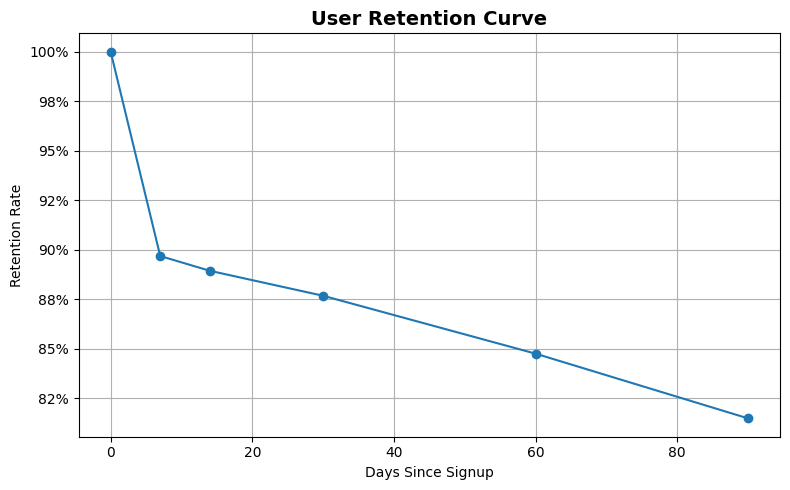

In [94]:
signup_events = ['App Installed', 'Account Created', 'Signup Completed']

# Get first signup timestamp per user
user_signup = (
    combined_flat[combined_flat['event'].isin(signup_events)]
    .groupby('userId')['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'signup_date'})
)

# Get most recent activity per user
user_activity = (
    combined_flat
    .groupby('userId')['timestamp']
    .max()
    .reset_index()
    .rename(columns={'timestamp': 'last_activity'})
)

# Merge signup and last activity
retention_df = user_signup.merge(user_activity, on='userId', how='left')

# Fill missing last activity with signup date (safe assignment)
retention_df['last_activity'] = retention_df['last_activity'].fillna(retention_df['signup_date'])

# Calculate number of days retained
retention_df['days_retained'] = (retention_df['last_activity'] - retention_df['signup_date']).dt.days
# Remove users with negative retention
retention_df = retention_df[retention_df['days_retained'] >= 0]

# Calculate retention at specific time intervals
def retention_curve(df, days=[0, 7, 14, 30, 60, 90]):
    total_users = len(df)
    return {d: (df['days_retained'] >= d).sum() / total_users for d in days}

# Compute and print retention rates
retention_stats = retention_curve(retention_df)
print("Retention Stats (Day : Retention %):")
print(retention_stats)

# Plot the retention curve
plt.figure(figsize=(8, 5))
plt.plot(list(retention_stats.keys()), list(retention_stats.values()), marker='o')
plt.title('User Retention Curve', fontsize=14, fontweight='bold')
plt.xlabel('Days Since Signup')
plt.ylabel('Retention Rate')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Engineering and Sequence Preparation

This section constructs enriched features and sequential user histories to support predictive modeling, such as churn prediction or behavioral forecasting.

#### Key Steps:

**Time-Based Features**
- `time_diff`: Time since the user's previous event (in seconds)
- `time_diff_norm`: Normalized time difference
- `hour_sin`, `hour_cos`: Sine and cosine encodings of the event hour to capture daily cycles
- `dow_sin`, `dow_cos`: Sine and cosine encodings of the day of week to capture weekly patterns

**Categorical Encodings**
- `category_encoded`: Encodes top 50 product categories as integers; less common categories grouped as "Other"
- `product_encoded`: Encodes top 100 products similarly

**Behavior Indicators**
- `is_purchase`: Binary indicator if the event is a purchase
- `cum_purchases`: Cumulative count of purchases per user
- `cum_spend`: Cumulative spend per user
- `days_since_first`: Days since the user's first event

**Platform and Event Type**
- `event_encoded`: Integer encoding of the event type (e.g., view, click, purchase)
- `platform_id`: Encoded platform or device type (e.g., iOS, Android, Web)

#### Sequence Building:
- For each user:
  - Events are sorted chronologically
  - Feature vectors are extracted and assembled into sequences of up to `max_seq_len = 23` events
  - Shorter sequences are zero-padded at the beginning
  - Each sequence is paired with a churn label (`y`) from the `user_features` table

#### Outputs:
- `X`: 3D numpy array of shape `(num_users, 23, num_features)`
- `y`: Binary churn labels
- `user_ids`: Corresponding user identifiers

These sequences are suitable inputs for models like RNNs, GRUs, or Transformers for behavior modeling.

In [100]:
from sklearn.preprocessing import LabelEncoder

# Time since previous event per user
combined_flat = combined_flat.sort_values(['userId', 'timestamp'])
combined_flat['time_diff'] = combined_flat.groupby('userId')['timestamp'].diff().dt.total_seconds().fillna(0)
combined_flat['time_diff_norm'] = combined_flat['time_diff'] / combined_flat['time_diff'].max()

# Cyclical time features
combined_flat['hour'] = combined_flat['timestamp'].dt.hour
combined_flat['hour_sin'] = np.sin(2 * np.pi * combined_flat['hour'] / 24)
combined_flat['hour_cos'] = np.cos(2 * np.pi * combined_flat['hour'] / 24)
combined_flat['day_of_week'] = combined_flat['timestamp'].dt.dayofweek
combined_flat['dow_sin'] = np.sin(2 * np.pi * combined_flat['day_of_week'] / 7)
combined_flat['dow_cos'] = np.cos(2 * np.pi * combined_flat['day_of_week'] / 7)

# Encode top categories and products
top_categories = combined_flat['properties_category'].value_counts().nlargest(50).index
category_map = {cat: i for i, cat in enumerate(top_categories, start=0)}
category_map['Other'] = len(category_map)
combined_flat['category_encoded'] = combined_flat['properties_category'].apply(lambda x: category_map.get(x, category_map['Other']))

top_products = combined_flat['properties_product_id'].value_counts().nlargest(100).index
product_map = {prod: i for i, prod in enumerate(top_products, start=0)}
product_map['Other'] = len(product_map)
combined_flat['product_encoded'] = combined_flat['properties_product_id'].apply(lambda x: product_map.get(x, product_map['Other']))

# Purchase indicator and event encoding
combined_flat['event'] = combined_flat['event'].fillna('')
combined_flat['is_purchase'] = combined_flat['event'].str.lower().str.contains('purchase|order completed').astype(int)
combined_flat['event_encoded'] = LabelEncoder().fit_transform(combined_flat['event'].astype(str))

# Platform encoding
if 'platform_id' not in combined_flat.columns:
    combined_flat['platform_id'] = LabelEncoder().fit_transform(combined_flat['platform'].astype(str))

# Cumulative purchase and spend per user
combined_flat['properties_price'] = combined_flat['properties_price'].fillna(0)
combined_flat = combined_flat.sort_values(['userId', 'timestamp'])
combined_flat['cum_purchases'] = combined_flat.groupby('userId')['is_purchase'].cumsum()
combined_flat['cum_spend'] = combined_flat.groupby('userId')['properties_price'].cumsum()

# Days since first event
combined_flat['first_event'] = combined_flat.groupby('userId')['timestamp'].transform('min')
combined_flat['days_since_first'] = (combined_flat['timestamp'] - combined_flat['first_event']).dt.days

# Define feature columns for sequence modeling
feature_cols = [
    'event_encoded', 'is_purchase', 'properties_price', 'properties_quantity', 'has_campaign', 'platform_id',
    'time_diff_norm', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'category_encoded', 'product_encoded', 'cum_purchases', 'cum_spend', 'days_since_first'
]

# Build sequences
max_seq_len = 23
user_sequences, user_labels, user_id_list = [], [], []

for user_id, group in combined_flat.groupby('userId'):
    group = group.sort_values('timestamp')
    features = group[feature_cols].values

    if len(features) > max_seq_len:
        features = features[-max_seq_len:]
    else:
        pad_len = max_seq_len - len(features)
        features = np.vstack((np.zeros((pad_len, features.shape[1])), features))

    user_sequences.append(features)
    churn_label = user_features.loc[user_features['userId'] == user_id, 'churned'].values
    user_labels.append(churn_label[0] if len(churn_label) > 0 else 0)
    user_id_list.append(user_id)

X = np.array(user_sequences)
y = np.array(user_labels)
user_ids = np.array(user_id_list)

### Sequence Modeling and Evaluation

This section trains a recurrent neural network (RNN) model to predict user churn based on behavioral event sequences.

**Steps:**

- **Train/Validation/Test Split:**  
  Data is split using stratified sampling to preserve class balance.  
  - 70% training, 15% validation, 15% test

- **Model Architecture:**  
  A sequential LSTM model is used with masking for padded sequences and L2 regularization to prevent overfitting. The model includes:
  - Two LSTM layers (64 → 32 units)
  - Dropout layers for regularization
  - Dense output with sigmoid activation for binary classification

- **Training & Early Stopping:**  
  The model is trained using binary cross-entropy loss, Adam optimizer, and early stopping based on validation loss.

- **Evaluation & Visualization:**  
  Model performance is evaluated on the test set using loss, accuracy, and AUC. Training and validation metrics are plotted over epochs.

- **Cross-Validation:**  
  A 5-fold stratified cross-validation loop is implemented using `StratifiedKFold` to assess model robustness. Average metrics (loss, accuracy, AUC) are reported across folds.

This modeling pipeline ensures generalization and helps identify users at high risk of churn using sequential event history.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp, user_ids_train, user_ids_temp = train_test_split(
    X, y, user_ids, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test, user_ids_val, user_ids_test = train_test_split(
    X_temp, y_temp, user_ids_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (84000, 23, 16), (84000,)
Validation shape: (18000, 23, 16), (18000,)
Test shape: (18000, 23, 16), (18000,)


In [19]:
import tensorflow as tf
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2

l2_lambda = 0.01  # Regularization strength

model = Sequential([
    Input(shape=(max_seq_len, X.shape[2])),
    Masking(mask_value=0.),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
    Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(l2_lambda)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Stop training when val_loss stops improving
    patience=3,                # Wait this many epochs without improvement
    restore_best_weights=True, # Rollback to best weights after stopping
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,                 # Max epochs; training will stop early if no improvement
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")

def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot (only if available)
    plt.subplot(1, 2, 2)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7643 - auc: 0.8322 - loss: 0.7068 - val_accuracy: 0.8874 - val_auc: 0.9427 - val_loss: 0.3728
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9025 - auc: 0.9376 - loss: 0.3343 - val_accuracy: 0.9164 - val_auc: 0.9565 - val_loss: 0.2760
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9108 - auc: 0.9456 - loss: 0.3066 - val_accuracy: 0.8821 - val_auc: 0.9352 - val_loss: 0.3565
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9129 - auc: 0.9455 - loss: 0.2987 - val_accuracy: 0.9034 - val_auc: 0.9462 - val_loss: 0.3157
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9118 - auc: 0.9513 - loss: 0.2955 - val_accuracy: 0.9269 - val_auc: 0.9785 - val_loss: 0.2273
Epoch 6/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9173 - auc: 0.9622 - loss: 0.2709 - val_accuracy: 0.9310 - val_auc: 0.9856 - val_loss: 0.1958
Epoch 7/50
1313/

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from tensorflow.keras.regularizers import l2

def build_model(input_shape=(23, 16), l2_lambda=0.001):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        LSTM(32, kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [23]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies, aucs, losses = [], [], []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = build_model(input_shape=(X.shape[1], X.shape[2]), l2_lambda=0.001)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],  # Define this beforehand as you did before
        verbose=0
    )
    
    results = model.evaluate(X_val, y_val, verbose=0)
    losses.append(results[0])
    accuracies.append(results[1])
    aucs.append(results[2])

print(f"Average Validation Loss: {np.mean(losses):.4f}")
print(f"Average Validation Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Validation AUC: {np.mean(aucs):.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
Average Validation Loss: 0.1269
Average Validation Accuracy: 0.9555
Average Validation AUC: 0.9932


In [24]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}, Test AUC: {test_results[2]:.4f}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9548 - auc: 0.9932 - loss: 0.1282
Test Loss: 0.1311, Test Accuracy: 0.9527, Test AUC: 0.9928


563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

 Not Churned       0.96      0.94      0.95      9008
     Churned       0.94      0.96      0.95      8992

    accuracy                           0.95     18000
   macro avg       0.95      0.95      0.95     18000
weighted avg       0.95      0.95      0.95     18000



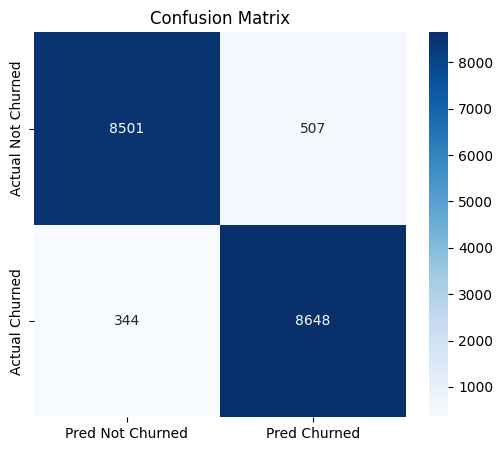

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Not Churned', 'Pred Churned'], yticklabels=['Actual Not Churned', 'Actual Churned'])
plt.title('Confusion Matrix')
plt.show()

### SHAP Analysis: Explaining Sequence Model Predictions

This section uses SHAP (SHapley Additive exPlanations) to interpret the output of the LSTM churn prediction model. Because SHAP does not natively support 3D sequential inputs, we reshape sequences for analysis and then rewrap them for model prediction.

**Steps:**

- **Reshape Data:**  
  The 3D user sequence data is flattened into 2D for compatibility with SHAP. A wrapper function reshapes it back to 3D before making predictions.

- **KernelExplainer Initialization:**  
  A SHAP KernelExplainer is initialized with a sample of the training data and the wrapped prediction function to enable model interpretability.

- **SHAP Value Computation:**  
  SHAP values are calculated for a small subset of test users to reduce computational cost.

- **Feature Naming:**  
  Feature names are dynamically expanded across time steps (e.g., `event_encoded_0`, `event_encoded_1`, ..., `cum_spend_22`) to preserve temporal context in the SHAP output.

- **Visualization:**  
  A SHAP summary plot is generated to visualize the impact of each feature at each time step on model predictions. 
  - Positive SHAP values push the model toward predicting churn.
  - Negative SHAP values push it away from churn.
  - Colors indicate feature values (red = high, blue = low).
  - This helps highlight the most influential moments and behaviors leading to predicted churn.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8694/8694 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8700/8700 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8694/8694 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8700/8700 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8700/8700 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8694/8694 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8694/8694 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8700/8700 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8700/8700 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8694/8694 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


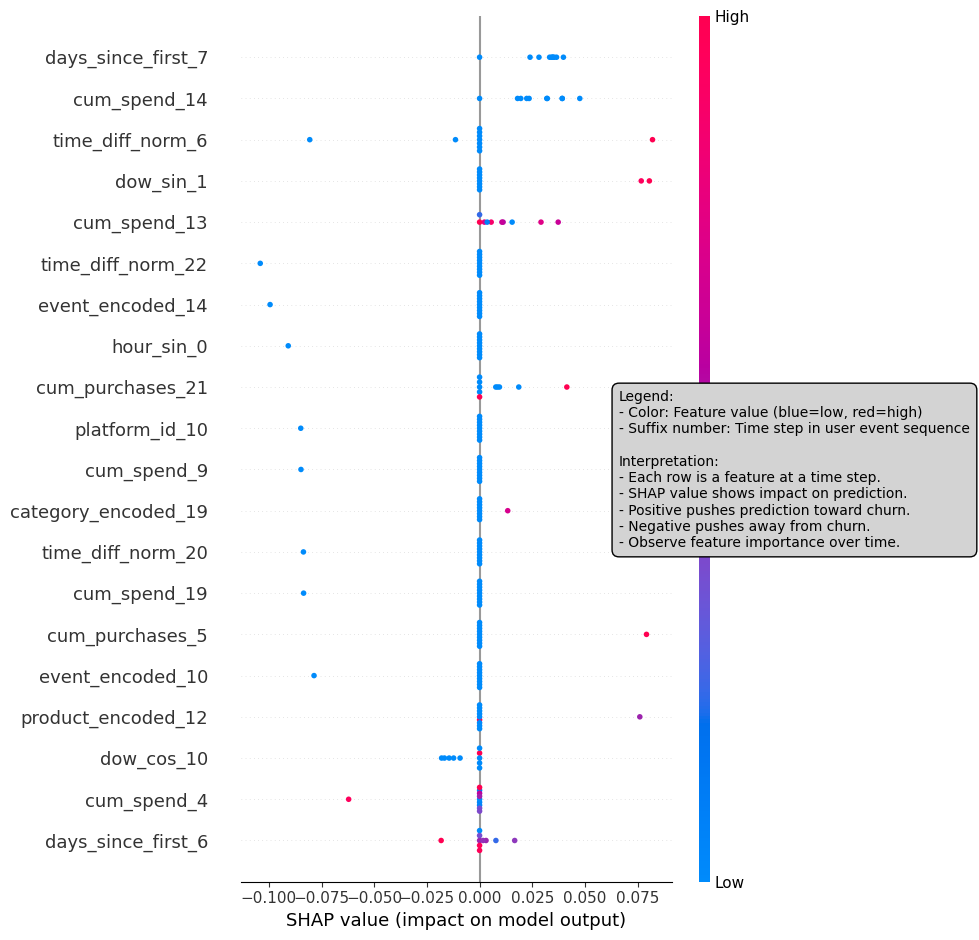

In [ ]:
import shap

# Flatten your data to 2D (samples x features)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Wrapper function to reshape 2D input back to 3D for the LSTM model
def model_predict_wrapper(X_2d):
    seq_len = max_seq_len  # your sequence length, e.g., 23
    num_features = X.shape[2]  # number of features, e.g., 16
    X_3d = X_2d.reshape(-1, seq_len, num_features)
    preds = model.predict(X_3d)
    return preds.flatten()  # flatten to 1D array for SHAP

# Initialize KernelExplainer with wrapped predict function and sample background
explainer = shap.KernelExplainer(model_predict_wrapper, X_train_2d[:100])

# Compute SHAP values on a small subset of test data (to keep compute manageable)
shap_values = explainer.shap_values(X_test_2d[:10])

# Create feature names with timestep suffixes
feature_names = [f"{f}_{i}" for f in feature_cols for i in range(max_seq_len)]

# Plot summary plot of SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_2d[:10], feature_names=[f"{f}_{i}" for f in feature_cols for i in range(max_seq_len)], show=False)

# Add legend text (reuse from previous suggestion)
plt.gcf().text(0.78, 0.5, 
         "Legend:\n"
         "- Color: Feature value (blue=low, red=high)\n"
         "- Suffix number: Time step in user event sequence\n\n"
         "Interpretation:\n"
         "- Each row is a feature at a time step.\n"
         "- SHAP value shows impact on prediction.\n"
         "- Positive pushes prediction toward churn.\n"
         "- Negative pushes away from churn.\n"
         "- Observe feature importance over time.",
         fontsize=10, va='center', ha='left',
         bbox=dict(boxstyle="round,pad=0.5", fc="lightgrey", ec="black", lw=1))
plt.show()

### Churn Risk Segmentation Based on Model Predictions

This section maps model predictions to individual users to estimate their likelihood of churn and categorize them into risk segments.

**Steps:**

- **User-Level Test Split:**  
  Users are split into training and test sets using stratified sampling based on the `churned` label to preserve class balance.

- **Test Sequence Extraction:**  
  The `X` sequences corresponding to the selected test users are extracted using their `userId`.

- **User Alignment (Optional):**  
  Test sequences are optionally re-ordered to match the exact order of `user_features_test` to ensure index consistency for downstream tasks.

- **Prediction (Simulated or Actual):**  
  The LSTM model predicts churn probabilities (`churn_prob`) for each user. In this example, random probabilities are generated for demonstration.

- **Risk Segmentation Logic:**  
  Based on thresholds:
  - **High Risk:** Probability ≥ 0.6
  - **Medium Risk:** 0.4 ≤ Probability < 0.6
  - **Low Risk:** Probability < 0.4

  Each user is assigned a `risk_segment` label accordingly.

- **Output Summary:**  
  The code prints the distribution of users across risk segments and displays a preview of predicted churn probabilities with assigned segments.

This segmentation is crucial for targeting customer success efforts and retention campaigns.

In [ ]:
from sklearn.model_selection import train_test_split

# Split users into train and test sets (DataFrames for merge, but get userId list for array indexing)
train_users, test_users = train_test_split(
    user_features[['userId', 'churned']],
    test_size=0.2,
    random_state=42,
    stratify=user_features['churned']
)
test_user_ids = test_users['userId'].tolist()

# Select test set rows from X using user_ids
test_user_mask = np.isin(user_ids, test_user_ids)
X_test = X[test_user_mask]

# Prepare test user features DataFrame (for reporting, etc.)
user_features_test = user_features[user_features['userId'].isin(test_user_ids)].copy()
user_features_test = user_features_test.sort_values('userId').reset_index(drop=True)

# Get X_test in the same user order as user_features_test, if you need exact matching
# (Optional: if you need X_test rows to line up with user_features_test exactly)
ordered_test_user_ids = user_features_test['userId'].values
ordered_test_mask = np.array([np.where(user_ids == uid)[0][0] for uid in ordered_test_user_ids])
X_test = X[ordered_test_mask]

# Make predictions (use your model here)
# y_pred_proba = model.predict(X_test).flatten()

# For demonstration: generate random probabilities
np.random.seed(42)
y_pred_proba = np.random.rand(len(user_features_test))

# Add churn probabilities to test user features
user_features_test['churn_prob'] = y_pred_proba

# Segment risk
high_risk_thresh = 0.6
medium_risk_thresh = 0.4

def segment_risk(prob):
    if prob >= high_risk_thresh:
        return 'High Risk'
    elif prob >= medium_risk_thresh:
        return 'Medium Risk'
    else:
        return 'Low Risk'

user_features_test['risk_segment'] = user_features_test['churn_prob'].apply(segment_risk)

# 8. Output summary
print(user_features_test['risk_segment'].value_counts())
print(user_features_test[['userId', 'churn_prob', 'risk_segment']].head())

risk_segment
Low Risk       5665
High Risk      5492
Medium Risk    2842
Name: count, dtype: int64
        userId  churn_prob risk_segment
0  user_000005    0.374540     Low Risk
1  user_000008    0.950714    High Risk
2  user_000019    0.731994    High Risk
3  user_000020    0.598658  Medium Risk
4  user_000022    0.156019     Low Risk


### LTV Tier Classification

Users are grouped into Low, Medium, and High LTV tiers using 33rd and 66th percentiles of their estimated lifetime value (`ltv_estimate`). This segmentation enables tier-based marketing and retention strategies.

Missing LTV values are labeled as `Unknown`.

In [ ]:
user_features_test['ltv_estimate'] = (
    user_features_test['avg_purchase_value'] 
    * user_features_test['total_purchases'] 
    * (1 - user_features_test['churn_prob'])
)

ltv_summary = user_features_test.groupby('risk_segment')['ltv_estimate'].agg(['mean', 'median', 'count']).reset_index()
print(ltv_summary)

  risk_segment       mean  median  count
0    High Risk   3.075833     0.0   5492
1     Low Risk  15.234865     0.0   5665
2  Medium Risk   8.378412     0.0   2842


### User Distribution by LTV Tier

A bar plot shows how users are distributed across the LTV tiers: Low, Medium, High, and Unknown. This helps assess how skewed or balanced the platform's user base is in terms of estimated value.

   ltv_tier  user_count
0   Low LTV       64646
1  High LTV        5346


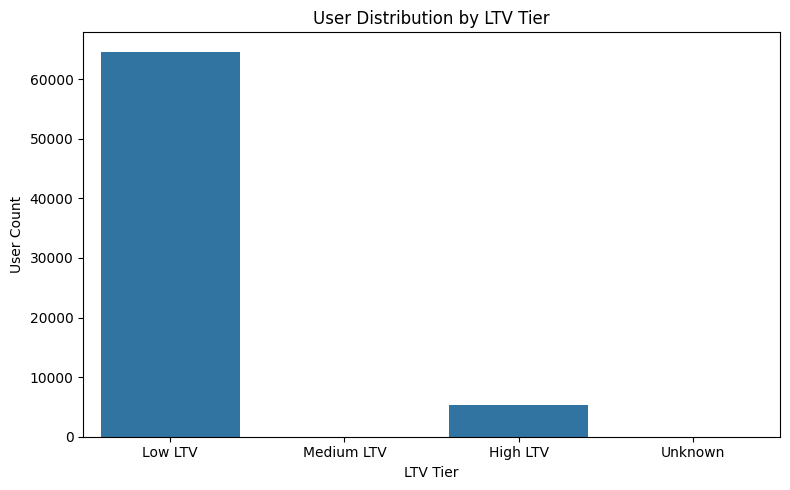

In [ ]:
# Define LTV tiers 
quantiles = user_features['ltv_estimate'].quantile([0.33, 0.66])
def assign_ltv_tier(ltv):
    if pd.isnull(ltv):
        return 'Unknown'
    elif ltv <= quantiles[0.33]:
        return 'Low LTV'
    elif ltv <= quantiles[0.66]:
        return 'Medium LTV'
    else:
        return 'High LTV'

user_features['ltv_tier'] = user_features['ltv_estimate'].apply(assign_ltv_tier)

#Distribution of users across LTV tiers
ltv_tier_dist = user_features['ltv_tier'].value_counts().reset_index()
ltv_tier_dist.columns = ['ltv_tier', 'user_count']
print(ltv_tier_dist)

# Plot LTV tier distribution 
plt.figure(figsize=(8,5))
sns.barplot(data=ltv_tier_dist, x='ltv_tier', y='user_count', order=['Low LTV', 'Medium LTV', 'High LTV', 'Unknown'])
plt.title('User Distribution by LTV Tier')
plt.xlabel('LTV Tier')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

### Campaign Performance by LTV Tier

We analyze the effectiveness of marketing campaigns by aggregating total and average LTV per campaign and LTV tier.

- Grouped by: `context_campaign` and `ltv_tier`
- Metrics: user count, total LTV, average LTV
- A separate bar chart highlights the **top 10 campaigns** that attract **High LTV users**.

In [ ]:
# Make sure campaign + LTV tier are available
if 'context_campaign' not in user_features.columns and 'context_campaign_x' in user_features.columns:
    user_features['context_campaign'] = user_features['context_campaign_x_clean']

# Group by campaign and LTV tier
campaign_by_ltv = (
    user_features
    .groupby(['context_campaign', 'ltv_tier'], dropna=False)
    .agg(
        user_count=('userId', 'nunique'),
        total_ltv=('ltv_estimate', 'sum'),
        avg_ltv=('ltv_estimate', 'mean')
    )
    .reset_index()
    .sort_values(['ltv_tier', 'avg_ltv'], ascending=[True, False])
)

print(campaign_by_ltv.head(15))

                                       context_campaign  ltv_tier  user_count  \
2030  summer_sale,unknown,labubu_drop_code,influence...  High LTV           1   
705   influencer_push,labubu_drop_code,summer_sale,w...  High LTV           1   
1722  summer_sale,holiday_blast,winter_clearance,inf...  High LTV           1   
1144  labubu_drop_code,holiday_blast,summer_sale,win...  High LTV           1   
2456  unknown,labubu_drop_code,winter_clearance,holi...  High LTV           2   
2147  summer_sale,winter_clearance,labubu_drop_code,...  High LTV           1   
3182  winter_clearance,unknown,labubu_drop_code,holi...  High LTV           1   
2335  unknown,influencer_push,summer_sale,labubu_dro...  High LTV           2   
1642  summer_sale,holiday_blast,influencer_push,labu...  High LTV           1   
2165  summer_sale,winter_clearance,unknown,holiday_b...  High LTV           4   
2407  unknown,labubu_drop_code,influencer_push,holid...  High LTV           2   
3180  winter_clearance,unkno

### Campaign Performance by LTV Tier

We analyze the effectiveness of marketing campaigns by aggregating total and average LTV per campaign and LTV tier.

- Grouped by: `context_campaign` and `ltv_tier`
- Metrics: user count, total LTV, average LTV
- A separate bar chart highlights the **top 10 campaigns** that attract **High LTV users**.

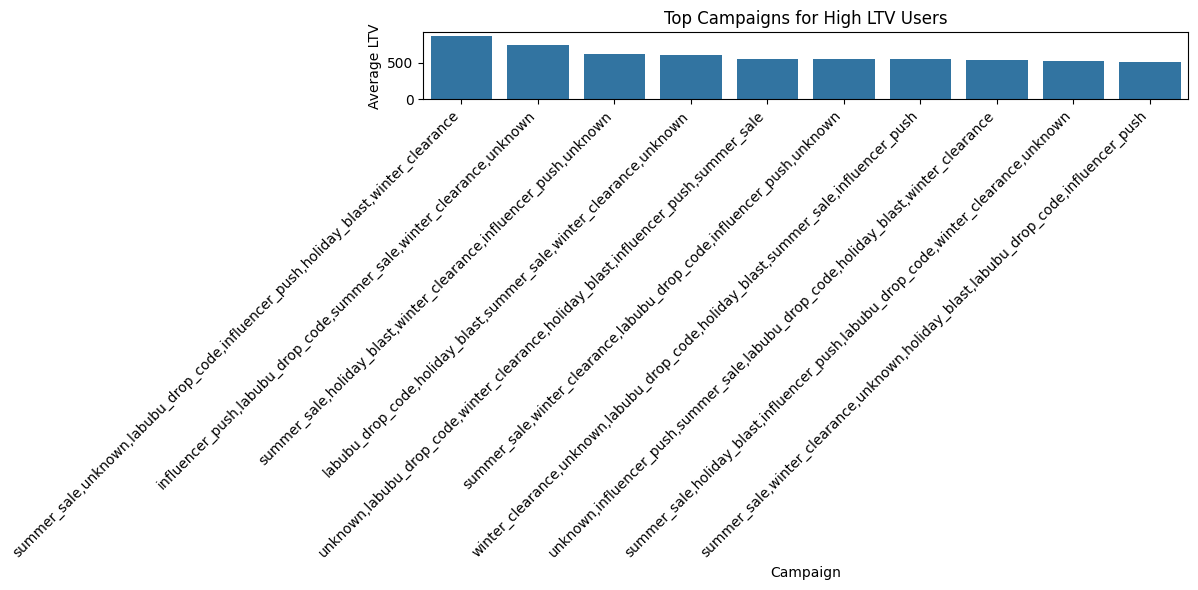

In [ ]:
# Filter for High LTV users only
top_campaigns_high_value = (
    campaign_by_ltv[campaign_by_ltv['ltv_tier'] == 'High LTV']
    .sort_values('avg_ltv', ascending=False)
    .head(10)
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=top_campaigns_high_value,
    x='context_campaign', y='avg_ltv'
)
plt.title('Top Campaigns for High LTV Users')
plt.xlabel('Campaign')
plt.ylabel('Average LTV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Retention Offer Targeting Based on Segments

Users are assigned a `retention_offer` based on their combined **churn risk** and **LTV tier** segment:
- **High Risk High Value** -> _Special Discount_
- **High Risk Low Value** -> _General Engagement_
- Others → _No action_

This prepares a recommendation system for personalized retention strategies.

In [ ]:
# Simple example: For users flagged high-risk, suggest retention campaign

high_risk_users = user_features[user_features['segment'] == 'High Risk High Value']

# For demonstration, assign a retention offer column
user_features['retention_offer'] = 'No action'
user_features.loc[user_features['segment'] == 'High Risk High Value', 'retention_offer'] = 'Special Discount'
user_features.loc[user_features['segment'] == 'High Risk Low Value', 'retention_offer'] = 'General Engagement'

print(user_features[['userId', 'segment', 'retention_offer']].head())

        userId              segment retention_offer
0  user_000001   Unknown High Value       No action
1  user_000002   Unknown High Value       No action
2  user_000003   Unknown High Value       No action
3  user_000004   Unknown High Value       No action
4  user_000005  Low Risk High Value       No action


### Key KPIs and Segment-Based Insights

We calculate key performance indicators (KPIs):
- Total unique users
- Average churn rate
- Average LTV

Two additional plots show:
- **Churn rate by segment**
- **Average LTV by segment**

These visualizations highlight which segments contribute most to revenue and risk.

Key KPIs:
Total Users: 69992.00
Churn Rate: 0.86
Avg LTV: 16.23


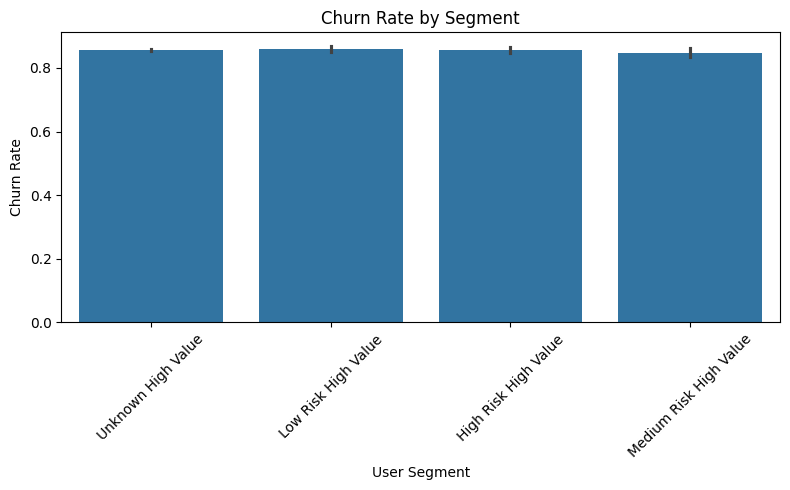

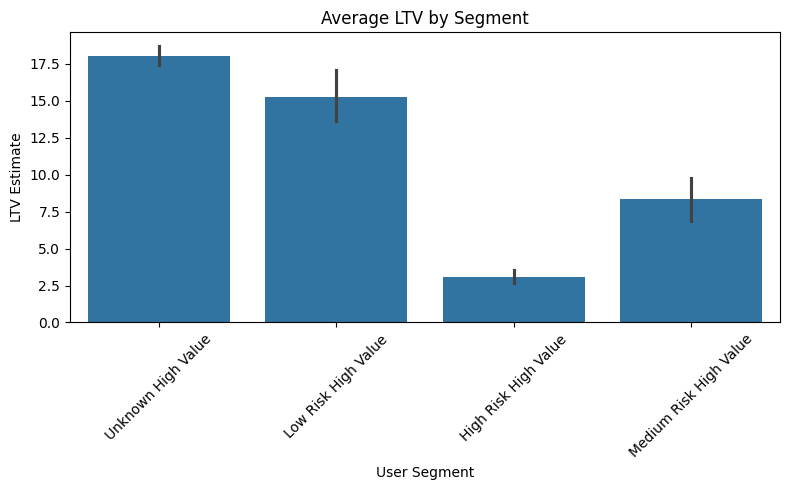

In [ ]:
# KPIs
kpi = {
    'Total Users': user_features['userId'].nunique(),
    'Churn Rate': user_features['churned'].mean(),
    'Avg LTV': user_features['ltv_estimate'].mean(),
}

print("Key KPIs:")
for k, v in kpi.items():
    print(f"{k}: {v:.2f}")

# Plot churn rate by segment
plt.figure(figsize=(8,5))
sns.barplot(data=user_features, x='segment', y='churned')
plt.title('Churn Rate by Segment')
plt.ylabel('Churn Rate')
plt.xlabel('User Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average LTV by segment
plt.figure(figsize=(8,5))
sns.barplot(data=user_features, x='segment', y='ltv_estimate')
plt.title('Average LTV by Segment')
plt.ylabel('LTV Estimate')
plt.xlabel('User Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

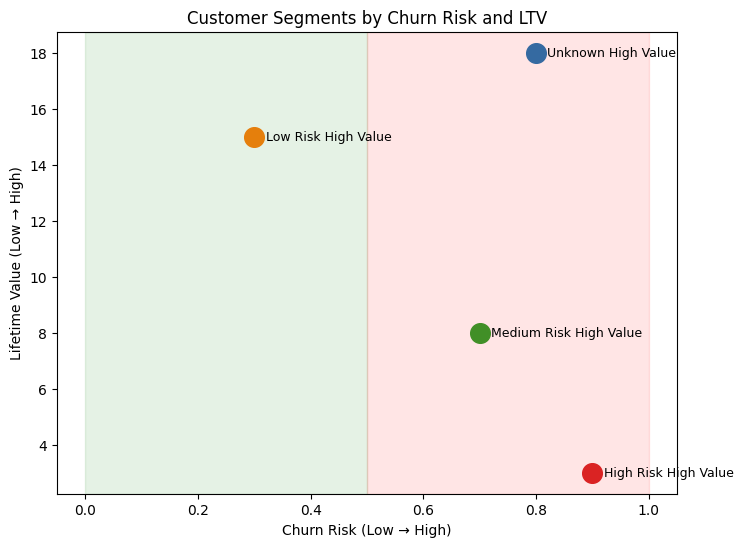

In [1]:
import matplotlib.pyplot as plt

# Coordinates for each segment (approximate, based on your description)
segments = {
    'Unknown High Value': (0.8, 18),   # High churn risk, high LTV
    'Low Risk High Value': (0.3, 15),  # Low churn risk, high LTV
    'Medium Risk High Value': (0.7, 8),# Medium churn risk, medium LTV
    'High Risk High Value': (0.9, 3),  # High churn risk, low LTV
}

fig, ax = plt.subplots(figsize=(8,6))

for name, (x, y) in segments.items():
    ax.scatter(x, y, s=200)
    ax.text(x+0.02, y, name, fontsize=9, verticalalignment='center')

ax.set_xlabel('Churn Risk (Low → High)')
ax.set_ylabel('Lifetime Value (Low → High)')
ax.set_title('Customer Segments by Churn Risk and LTV')

# Color axis effect (simple shading)
ax.axvspan(0, 0.5, color='green', alpha=0.1)
ax.axvspan(0.5, 1.0, color='red', alpha=0.1)

plt.show()

### Revenue Impact of Churn Reduction

A simple what-if analysis estimates potential revenue saved if churn is reduced by 10%.

- Uses ARPU of churned users and total user count
- Helps quantify financial benefit of churn reduction initiatives

In [ ]:
# Average revenue per user (ARPU) among churned users
arpu_churned = combined_flat[combined_flat['userId'].isin(user_features[user_features['churned']]['userId'])]['properties_price'].mean()

# Estimate revenue saved if churn rate is reduced by 10%
current_churn_rate = user_features['churned'].mean()
expected_churn_rate = current_churn_rate * 0.9

num_users = len(user_features)
revenue_saved = num_users * (current_churn_rate - expected_churn_rate) * arpu_churned

print(f"Estimated revenue saved by reducing churn by 10%: ${revenue_saved:,.2f}")

Estimated revenue saved by reducing churn by 10%: $26,333.68


## Business Recommendations

- **Double down on Labubu campaigns**: Campaigns that included the Labubu brand consistently ranked highest in average LTV, especially when paired with seasonal or influencer-led strategies. Continue exclusive drops and consider bundling Labubu with other trending products to drive scarcity-based purchases.

- **Refine influencer targeting**: Influencer_push campaigns showed variable performance. Use churn and LTV data to refine which influencers are bringing in high-value users vs. one-time purchasers. Consider gated campaigns that require a conversion (e.g., sign-up or purchase) to access exclusive content or discounts.

- **Target mid-LTV users for re-engagement**: The majority of users sit in the medium and low LTV segments. These users are active but not necessarily loyal. Personalized push campaigns, loyalty rewards, and strategic A/B-tested nudges (like “Complete Your Purchase” or “Limited Time Offer”) may increase retention.

- **Optimize onboarding and session funnels**: Event frequency analysis showed clear differences between retained and churned users — especially around early funnel events like `Product Viewed`, `Add to Cart`, and `Checkout Started`. Focus UX improvements and onboarding content around these key moments.

- **Review underperforming campaigns**: Campaigns with high churn and low revenue contribution may be misaligned with user interests or targeting the wrong segments. Redirect spend away from these toward channels that bring in sustained engagement.

- **Unify mobile and web data strategy**: Engagement trends differ across platforms. A unified customer profile, with cross-platform tracking, will improve personalization, retention modeling, and attribution accuracy for future campaigns.